# Survival Analysis with Neural Networks
This notebook demonstrates a complete workflow for survival analysis using a custom multi-task neural network model. The notebook covers data preparation, model definition, training, and evaluation.

# Data Preparation

## installing the necessary libraries.

In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam


## Loading the dataset from an Excel file and performing necessary preprocessing

In [ ]:
data = pd.read_excel('4A_TB_cleaned.xlsx')
data.head()

,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,MARITAL STATUS,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
1,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
2,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
3,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
4,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,2,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1


In [ ]:
# Drop duplicate rows, keeping only the first occurrence.
data = data.drop_duplicates()


In [ ]:
data.shape

(4092, 18)

In [ ]:

# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(4092, 12)

In [ ]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
2,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0
3,M,22,CATHOLIC,CENTRAL,0,Abdominal_TB,8,Monday,December,2010,9,0
4,F,18,COU,CENTRAL,0,PTB,4,Thursday,January,2011,5,0


In [ ]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [ ]:

# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1.010431,-0.700413,0.353972,2010,-0.559238,0,1.626162,-0.413998,1,0,...,0,0,0,0,0,0,1,0,0,0
2,4.170011,0.597635,1.304868,2010,-0.046086,0,1.626162,-0.323601,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-1.219861,-1.998462,1.542592,2010,0.082202,0,1.626162,-0.413998,0,1,...,0,0,0,0,1,0,0,0,0,0
4,-1.591577,-1.998462,0.591696,2011,-0.430950,0,-1.576218,-0.278403,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:

dataset['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,2781
1,1311


## Splitting Data and Converting Data to TensorFlow Dataset


In [ ]:

dataset['YEAR OF ADMISSION'].value_counts()

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [ ]:
train_data.shape

(3267, 25)

In [ ]:
test_data.shape

(825, 25)

# **Model Training**

## Define the Multi-Task Model
A BaseMultiTaskModel class for our survival analysis is difined.

***Proposed model***

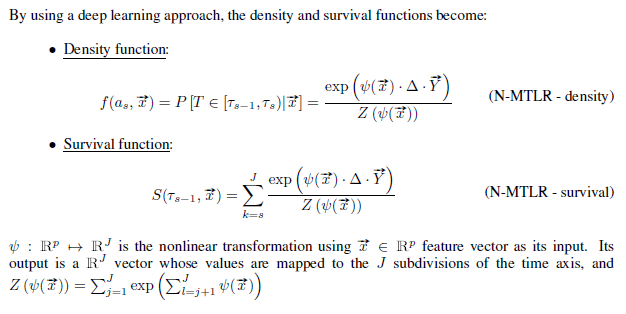





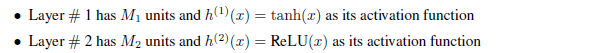


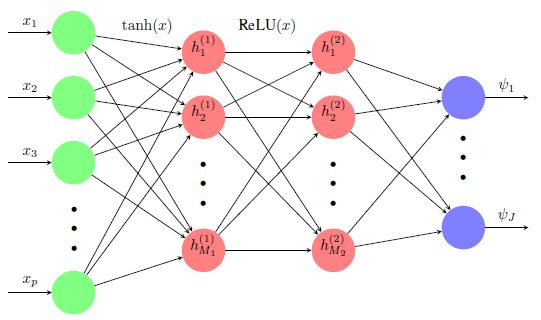

# train 2

In [ ]:
import torch

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins, dropout_rate=0.7, l2_lambda=0.001, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.num_times = bins - 1
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_initializer(self):
        """
        Define the initializer for the model.
        """
        return tf.keras.initializers.GlorotUniform()

    def loss_function(self, Triangle, l2_reg, l2_smooth):
        """
        A closure to define a custom loss function with additional arguments.
        """
        def custom_loss(y_true, y_pred):
            # Extracting censored and uncensored data using y_true
            Y_cens = y_true[:, :self.num_times+1]
            Y_uncens = y_true[:, self.num_times+1:2*(self.num_times+1)]
            X_uncens = y_true[:, 2*(self.num_times+1):]

            # Likelihood Calculations -- Uncensored
            phi_uncens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_phi_uncens = tf.reduce_sum(phi_uncens * Y_uncens, axis=1)

            # Likelihood Calculations -- Censored
            phi_cens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_phi_cens = tf.reduce_sum(phi_cens * Y_cens, axis=1)

            # Likelihood Calculations -- Normalization
            z_uncens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

            z_cens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_z_cens = tf.reduce_sum(z_cens, axis=1)

            # MTLR cost function
            loss = -(
                tf.reduce_sum(tf.math.log(reduc_phi_uncens + K.epsilon())) +
                tf.reduce_sum(tf.math.log(reduc_phi_cens + K.epsilon())) -
                tf.reduce_sum(tf.math.log(reduc_z_uncens + K.epsilon())) -
                tf.reduce_sum(tf.math.log(reduc_z_cens + K.epsilon()))
            )

            # Adding the regularized loss
            for w in self.model.trainable_weights:
                loss += l2_reg * tf.reduce_sum(tf.square(w)) / 2.0
                # Ensure smooth variation across consecutive time points (for the last layers)
                loss += l2_smooth * tf.reduce_sum(tf.square(w[:-1] - w[1:])) / 2.0

            return loss

        return custom_loss

    def build_model(self, input_shape, Triangle, l2_reg=0.01, l2_smooth=0.01):
        """
        Build the neural network model.

        Parameters:
        input_shape (int): Dimension of the input features.
        Triangle: matrix for use in the loss function
        l2_reg: L2 regularization factor
        l2_smooth: L2 smoothing factor

        Returns:
        tf.keras.Model: The compiled model.
        """
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        self.model = Model(inputs=inputs, outputs=outputs)

        # Create the custom loss function with captured arguments
        custom_loss_fn = self.loss_function(
            Triangle=Triangle,
            l2_reg=l2_reg,
            l2_smooth=l2_smooth
        )

        self.model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=custom_loss_fn)
        return self.model

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        """
        Compute the design matrices for censored and uncensored data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.

        Returns:
        Tuple: Design matrices (X_cens, X_uncens, Y_cens, Y_uncens).
        """
        # For demonstration, we'll return dummy values
        # In a real implementation, you would use `X`, `T`, and `E` to create these matrices
        X_cens = X
        X_uncens = X
        Y_cens = np.random.rand(X.shape[0], self.num_times + 1)
        Y_uncens = np.random.rand(X.shape[0], self.num_times + 1)
        return X_cens, X_uncens, Y_cens, Y_uncens

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        """
        Fit the model to the data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
        validation_split (float): Fraction of the data to use for validation.
        verbose (bool): Whether to print detailed logs during training.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        # Construct Triangle matrix (adjust size accordingly)
        Triangle = np.eye(self.num_times + 1, self.num_times + 1)

        self.model = self.build_model(self.num_vars, Triangle)

        # Combine X_uncens, Y_cens, Y_uncens into a single y_true
        Y_cens = np.hstack((Y_cens, np.zeros_like(Y_cens), X_uncens))
        Y_uncens = np.hstack((np.zeros_like(Y_uncens), Y_uncens, X_uncens))
        y_true = np.vstack((Y_cens, Y_uncens))

        # Train the model
        history = self.model.fit(X_uncens, y_true, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

        return self.model

    def plot_loss(self):
        """
        Plot training and validation loss over epochs.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()



    def predict(self, X):
        """Perform prediction to obtain survival probabilities (for evaluation)."""
        if self.auto_scaler:
            X = self.scaler.transform(X)
        survival_predictions = self.model.predict(X)  # Use Keras' predict method
        return survival_predictions

    def evaluate(self, X, T, E):
        """
        Evaluate the model using the concordance index and integrated Brier score.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.

        Returns:
        float: Concordance index, Integrated Brier score.
        """
        # Scale the features
        if self.auto_scaler:
            X = self.scaler.transform(X)

        # Get predictions
        Survival = self.predict(X)

        # Calculate concordance index
        # c_index = Surv(E == 1, T).score_survival_function(-Survival[:, -1])[0]
        c_index = concordance_index_censored(E.astype(bool), T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        # Binary classification at a chosen threshold (e.g., 0.5)
        risk_threshold = 0.5
        predicted_events = (Survival[:, -1] > risk_threshold).astype(int)

        # Accuracy
        accuracy = accuracy_score(E, predicted_events)

        # ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(E, Survival[:, -1])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        self.plot_roc_curve(fpr, tpr, roc_auc)

        # Plot Brier Score and Actual vs. Predicted Events
        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score, accuracy, roc_auc

        # # Plot the results
        # self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        # self.plot_actual_vs_predicted(T, E, Survival)

        # return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        """Plot the Brier score curve."""
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        """Plot the actual vs. predicted number of events over time."""
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_roc_curve(self, fpr, tpr, roc_auc):
        """
        Plot the ROC curve.

        Parameters:
        fpr (np.ndarray): False positive rates.
        tpr (np.ndarray): True positive rates.
        roc_auc (float): Area under the ROC curve.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()






# Example usage



In [ ]:
# Assuming you have `train_data` with `X`, `T`, `E` defined

structure = [{'activation': 'tanh', 'num_units': 128},
             {'activation': 'relu', 'num_units': 32}]

# Create the model
model = BaseMultiTaskModel(structure=structure, bins=28)

# Fit the model (replace train_data[X], train_data[T], train_data[E] with actual data)
model.fit(train_data[X], train_data[T], train_data[E], epochs=500, batch_size=32, verbose=True, validation_split=0.2)

Epoch 1/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 662.8975 - val_loss: 654.5493
Epoch 2/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 663.0945 - val_loss: 654.4867
Epoch 3/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.8502 - val_loss: 654.4245
Epoch 4/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.6708 - val_loss: 654.3629
Epoch 5/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.6119 - val_loss: 654.3014
Epoch 6/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.8250 - val_loss: 654.2407
Epoch 7/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.4841 - val_loss: 654.1797
Epoch 8/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.6782 - val_loss: 654.1194
Epoch 9/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.5046 - val_loss: 654.0583
Epoch 10/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.3721 - val_loss: 653.9983
Epoch 11/1000
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 662.2547 - val_loss: 653.9384
Epoch 12

<Functional name=functional_8, built=True>

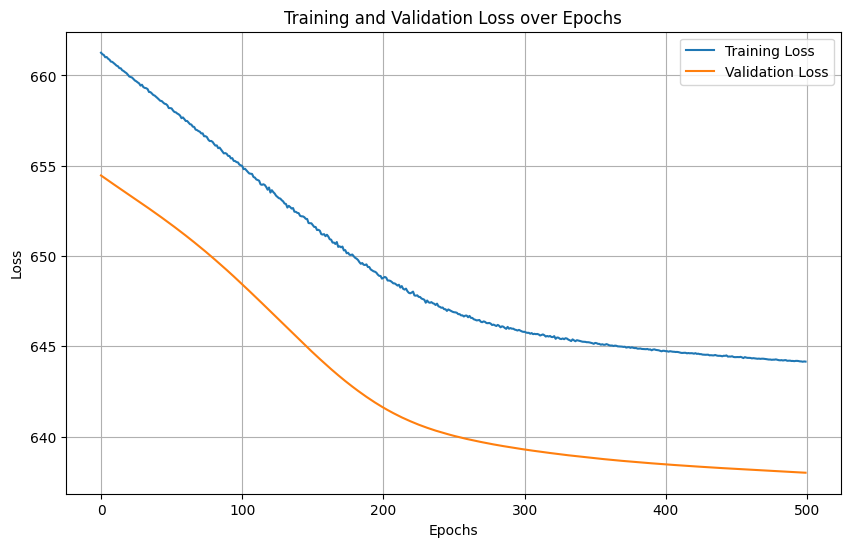

In [ ]:
model.plot_loss()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


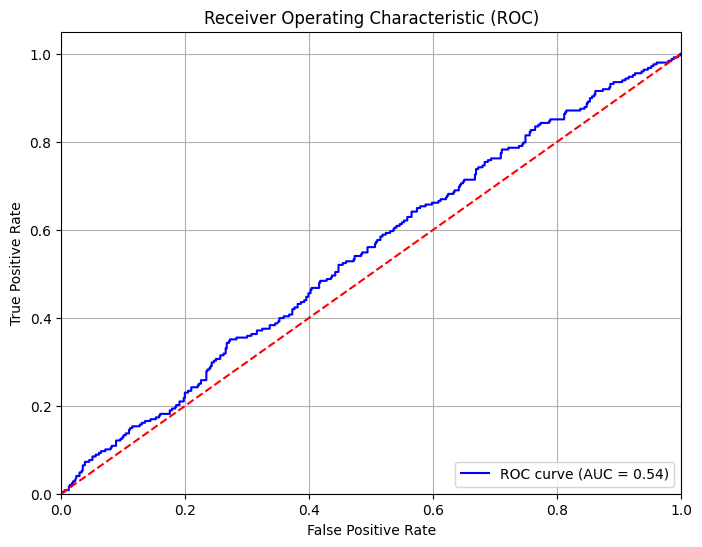

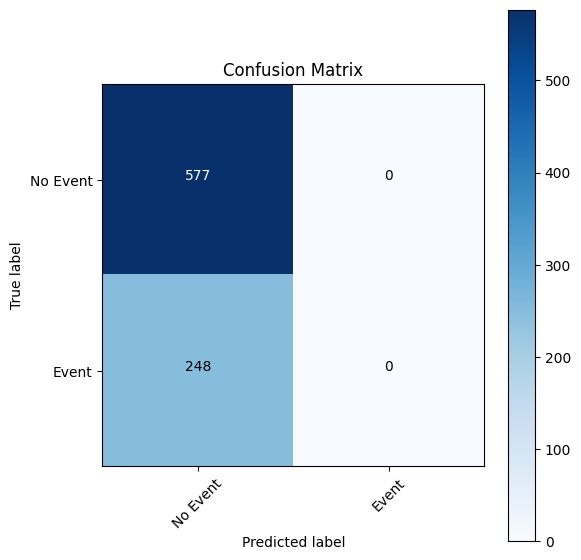

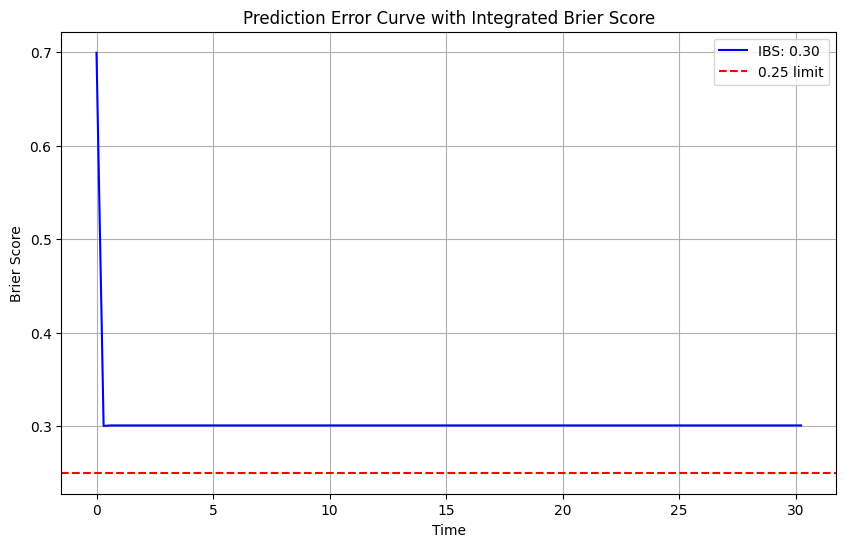

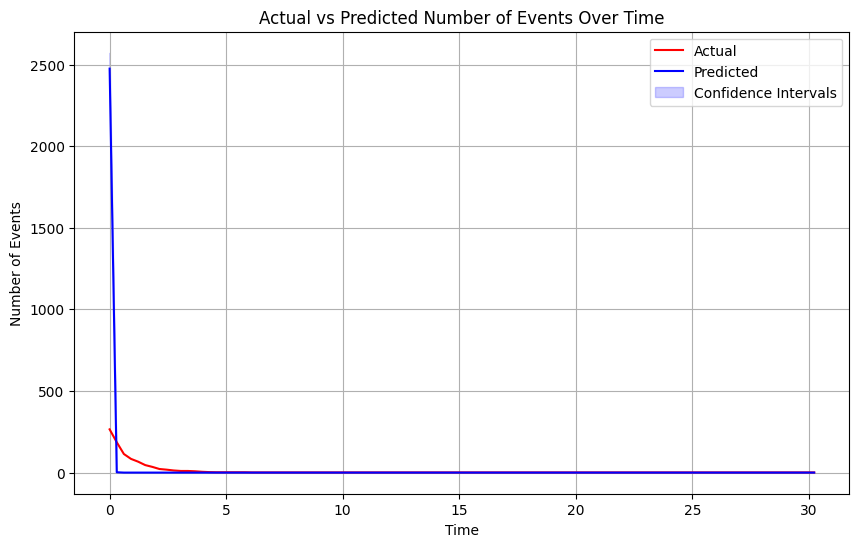

Concordance Index: 0.4666
Integrated Brier Score: 0.3026
Accuracy: 0.6994
ROC AUC: 0.5445


In [ ]:
c_index, integrated_brier_score, accuracy, roc_auc= model.evaluate(test_data[X], test_data[T], test_data[E])

print(f'Concordance Index: {c_index:.4f}')
print(f'Integrated Brier Score: {integrated_brier_score:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')